# Load Data and Packages

In [1]:
from google.colab import files
uploaded = files.upload()

Saving airbnb_model.csv to airbnb_model.csv


In [2]:
# load packages
%matplotlib inline
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
import sklearn as sl
from sklearn import preprocessing
pd.set_option('display.float_format', lambda x: '%.3f' % x)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import io
import pandas as pd
df = pd.read_csv(io.BytesIO(uploaded['airbnb_model.csv']), index_col=False)

In [4]:
df.info()
#df.describe(percentiles = [.1, .25, .5, .75, .95])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26393 entries, 0 to 26392
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          26393 non-null  int64  
 1   guest_size          26392 non-null  float64
 2   total_interactions  26393 non-null  int64  
 3   message_length      26393 non-null  float64
 4   channel             26393 non-null  object 
 5   user_stage          26393 non-null  object 
 6   total_reviews       26309 non-null  float64
 7   lead_time           26393 non-null  int64  
 8   days_of_stay        26393 non-null  int64  
 9   reply_t             14319 non-null  float64
 10  accept_t            15247 non-null  float64
 11  replied             26393 non-null  int64  
 12  accepted            26393 non-null  int64  
 13  booked              26393 non-null  int64  
dtypes: float64(5), int64(7), object(2)
memory usage: 2.8+ MB


# Feature Preprocessing

In [0]:
# Drop useless column
df = df.drop(columns=['Unnamed: 0'])

In [0]:
# from google.colab import files

# df.to_csv('airbnb_model.csv')
# files.download('airbnb_model.csv')

## Filling missing data

Guest size, total_reviews have nulls.

Deal with nulls in reply_t and accept_t later.

In [0]:
# Replace guest size, total review with median 
df['total_reviews'].fillna(df['total_reviews'].median(), inplace=True)
df['guest_size'].fillna(df['guest_size'].median(), inplace=True)

## Feature encoding

In order to see the nuances of some features' impact, I decided to create buckets for numerical variables including:
*   Interaction
*   Review
*   Lead time
*   Days of stay
*   Message length
*   Guest size



And these bins will be used to create interactive features as well




In [0]:
# Binning the numerical features first

# Binning interactions
interaction = [0,10,20,30,1000]
interaction_range = ['1-10','11-20','21-30','>30']
interactions_bin = pd.cut(df['total_interactions'], bins = interaction, labels= interaction_range)
df['interactions'] = interactions_bin

# Binning reviews
review = [-1,0,10,20,30,1000]
review_range = ['0','1-10','11-20','21-30','>30']
reviews_bin = pd.cut(df['total_reviews'], bins = review, labels=review_range)
df['reviews'] = reviews_bin

# Binning lead time
lead = [-1,30,60,90,1000]
lead_range = ['1-30d','31-60d','61-90d', '>90d']
lead_bin = pd.cut(df['lead_time'], bins = lead, labels=lead_range)
df['lead_time_bin'] = lead_bin

# Binning days_of_stay
stay = [-1,5,10,15,1000]
stay_range = ['1-5d','6-10d','11-15d','>15d']
stay_bin = pd.cut(df['days_of_stay'], bins = stay, labels=stay_range)
df['days_of_stay_bin'] = stay_bin

# Binning message_length
length = [-1,150,300,450,3000]
length_range = ['0-150','151-300','301-450','>450']
length_bin = pd.cut(df['message_length'], bins = length, labels=length_range)
df['message_length_bin'] = length_bin

# Binning guest size
size = [-1,1,2,4,6,30]
size_range = ['1','2','3-4','5-6','>6']
size_bin = pd.cut(df['guest_size'], bins = size, labels=size_range)
df['guest_size_bin'] = size_bin

In [0]:
# One-hot-encoding each bin

# Interactions
df['1-10_interactions'] = np.where(df['interactions'] == '1-10', 1, 0)
df['11-20_interactions'] = np.where(df['interactions'] == '11-20', 1, 0)
df['21-30_interactions'] = np.where(df['interactions'] == '21-30', 1, 0)
df['>30_interactions'] = np.where(df['interactions'] == '>30', 1, 0)

# Reviews
df['0_reviews'] = np.where(df['reviews'] == '0', 1, 0)
df['1-10_reviews'] = np.where(df['reviews'] == '1-10', 1, 0)
df['11-20_reviews'] = np.where(df['reviews'] == '11-20', 1, 0)
df['21-30_reviews'] = np.where(df['reviews'] == '21-30', 1, 0)
df['>30_reviews'] = np.where(df['reviews'] == '>30', 1, 0)

# Lead time
df['1-30d_lead_time'] = np.where(df['lead_time_bin'] == '1-30d', 1, 0)
df['31-60d_lead_time'] = np.where(df['lead_time_bin'] == '31-60d', 1, 0)
df['61-90d_lead_time'] = np.where(df['lead_time_bin'] == '61-90d', 1, 0)
df['>90d_lead_time'] = np.where(df['lead_time_bin'] == '>90d', 1, 0)

# Days of stay
df['1-5d_stay'] = np.where(df['days_of_stay_bin'] == '1-5d', 1, 0)
df['6-10d_stay'] = np.where(df['days_of_stay_bin'] == '6-10d', 1, 0)
df['11-15d_stay'] = np.where(df['days_of_stay_bin'] == '11-15d', 1, 0)
df['>15d_stay'] = np.where(df['days_of_stay_bin'] == '>15d', 1, 0)

# Message length
df['0-150_char_message'] = np.where(df['message_length_bin'] == '0-150', 1, 0)
df['151-300_char_message'] = np.where(df['message_length_bin'] == '151-300', 1, 0)
df['301-450_char_message'] = np.where(df['message_length_bin'] == '301-450', 1, 0)
df['>450_char_message'] = np.where(df['message_length_bin'] == '>450', 1, 0)

# Guest size
size = [-1,1,2,4,6,30]
size_range = ['1','2','3-4','5-6','>6']
df['1_guest'] = np.where(df['guest_size_bin'] == '1', 1, 0)
df['2_guests'] = np.where(df['guest_size_bin'] == '2', 1, 0)
df['3-4_guests'] = np.where(df['guest_size_bin'] == '3-4', 1, 0)
df['5-6_guests'] = np.where(df['guest_size_bin'] == '5-6', 1, 0)
df['>6_guests'] = np.where(df['guest_size_bin'] == '>6', 1, 0)

In [0]:
# Categorical features 
df['contact_me'] = np.where(df['channel'] == 'contact_me', 1, 0)
df['past_booker'] = np.where(df['user_stage'] == 'past_booker', 1, 0)

In [0]:
# Drop original numerical/categorical features 
df = df.drop(columns=['total_interactions', 'total_reviews', 'lead_time', 'days_of_stay', 'message_length', 'guest_size', 'interactions', 'reviews', 'lead_time_bin',	'days_of_stay_bin',	'message_length_bin', 'guest_size_bin', 'user_stage'])

## Interactive features

In [0]:
interactions = ['1-10_interactions', '11-20_interactions', '21-30_interactions', '>30_interactions']
reviews = ['0_reviews', '1-10_reviews', '11-20_reviews', '21-30_reviews', '>30_reviews']
lead_times = ['1-30d_lead_time', '31-60d_lead_time', '61-90d_lead_time', '>90d_lead_time']
stays = ['1-5d_stay', '6-10d_stay', '11-15d_stay', '>15d_stay']
message_lengths = ['0-150_char_message', '151-300_char_message', '301-450_char_message', '>450_char_message']
guest_sizes = ['1_guest', '2_guests', '3-4_guests', '5-6_guests', '>6_guests']

# Interaction * message length
for i in interactions:
  for j in message_lengths:
    df[i+'*'+j] = df[i] * df[j]

# Interaction * lead time
for i in interactions:
  for j in lead_times:
    df[i+'*'+j] = df[i] * df[j]

# Interaction * days of stay
for i in interactions:
  for j in stays:
    df[i+'*'+j] = df[i] * df[j]

# User stage + interactions
for i in interactions:
    df['past_booker'+'*'+i] = df['past_booker'] * df[i]

# Channel * user stage
df['contact_me*past_booker'] = df['contact_me'] * df['past_booker']

# Channel * lead_time
for i in lead_times:
  df['contact_me'+'*'+i] = df['contact_me'] * df[i]

# Channel * guest size
for i in guest_sizes:
  df['contact_me'+'*'+i] = df['contact_me'] * df[i]

# Message length * days of stay
for i in message_lengths:
  for j in stays:
    df[i+'*'+j] = df[i] * df[j]

# Message length * lead time
for i in message_lengths:
  for j in lead_times:
    df[i+'*'+j] = df[i] * df[j]


In [214]:
df.head(10)

,channel,reply_t,accept_t,replied,accepted,booked,1-10_interactions,11-20_interactions,21-30_interactions,>30_interactions,0_reviews,1-10_reviews,11-20_reviews,21-30_reviews,>30_reviews,1-30d_lead_time,31-60d_lead_time,61-90d_lead_time,>90d_lead_time,1-5d_stay,6-10d_stay,11-15d_stay,>15d_stay,0-150_char_message,151-300_char_message,301-450_char_message,>450_char_message,1_guest,2_guests,3-4_guests,5-6_guests,>6_guests,contact_me,past_booker,1-10_interactions*0-150_char_message,1-10_interactions*151-300_char_message,1-10_interactions*301-450_char_message,1-10_interactions*>450_char_message,11-20_interactions*0-150_char_message,11-20_interactions*151-300_char_message,...,contact_me*31-60d_lead_time,contact_me*61-90d_lead_time,contact_me*>90d_lead_time,contact_me*1_guest,contact_me*2_guests,contact_me*3-4_guests,contact_me*5-6_guests,contact_me*>6_guests,0-150_char_message*1-5d_stay,0-150_char_message*6-10d_stay,0-150_char_message*11-15d_stay,0-150_char_message*>15d_stay,151-300_char_message*1-5d_stay,151-300_char_message*6-10d_stay,151-300_char_message*11-15d_stay,151-300_char_message*>15d_stay,301-450_char_message*1-5d_stay,301-450_char_message*6-10d_stay,301-450_char_message*11-15d_stay,301-450_char_message*>15d_stay,>450_char_message*1-5d_stay,>450_char_message*6-10d_stay,>450_char_message*11-15d_stay,>450_char_message*>15d_stay,0-150_char_message*1-30d_lead_time,0-150_char_message*31-60d_lead_time,0-150_char_message*61-90d_lead_time,0-150_char_message*>90d_lead_time,151-300_char_message*1-30d_lead_time,151-300_char_message*31-60d_lead_time,151-300_char_message*61-90d_lead_time,151-300_char_message*>90d_lead_time,301-450_char_message*1-30d_lead_time,301-450_char_message*31-60d_lead_time,301-450_char_message*61-90d_lead_time,301-450_char_message*>90d_lead_time,>450_char_message*1-30d_lead_time,>450_char_message*31-60d_lead_time,>450_char_message*61-90d_lead_time,>450_char_message*>90d_lead_time
0,book_it,nan,-0.100,1,1,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,contact_me,-0.119,nan,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,contact_me,-0.112,nan,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,contact_me,nan,-0.100,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,instant_book,-0.127,-0.100,1,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,contact_me,-0.103,nan,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,contact_me,-0.127,0.664,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7,instant_book,nan,-0.100,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,instant_book,nan,-0.100,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,book_it,-0.126,nan,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


## Feature scaling

In [0]:
# Scale reply_t and accept_t
from sklearn import preprocessing
sc_scale = preprocessing.StandardScaler().fit(df[['reply_t', 'accept_t']])
df[['reply_t', 'accept_t']] = sc_scale.transform(df[['reply_t', 'accept_t']])

## Split dataset by step

In [0]:
# All inquiries to predict reply, leave out Instant Book
all_inquiries = df[df['channel'] != 'instant_book'].copy()

# Rplied inquiries to predict acceptance
replied_inquiries = all_inquiries[all_inquiries['replied'] == 1].copy()

# Accepted inquiries to predict booking, leave out book it channel
accepted_inquiries = replied_inquiries[replied_inquiries['accepted'] == 1].copy() 
accepted_inquiries = accepted_inquiries[accepted_inquiries['channel'] != 'book_it']

In [216]:
all_inquiries.head(10)
#replied_inquiries.info()
#accepted_inquiries.info()

,channel,reply_t,accept_t,replied,accepted,booked,1-10_interactions,11-20_interactions,21-30_interactions,>30_interactions,0_reviews,1-10_reviews,11-20_reviews,21-30_reviews,>30_reviews,1-30d_lead_time,31-60d_lead_time,61-90d_lead_time,>90d_lead_time,1-5d_stay,6-10d_stay,11-15d_stay,>15d_stay,0-150_char_message,151-300_char_message,301-450_char_message,>450_char_message,1_guest,2_guests,3-4_guests,5-6_guests,>6_guests,contact_me,past_booker,1-10_interactions*0-150_char_message,1-10_interactions*151-300_char_message,1-10_interactions*301-450_char_message,1-10_interactions*>450_char_message,11-20_interactions*0-150_char_message,11-20_interactions*151-300_char_message,...,contact_me*31-60d_lead_time,contact_me*61-90d_lead_time,contact_me*>90d_lead_time,contact_me*1_guest,contact_me*2_guests,contact_me*3-4_guests,contact_me*5-6_guests,contact_me*>6_guests,0-150_char_message*1-5d_stay,0-150_char_message*6-10d_stay,0-150_char_message*11-15d_stay,0-150_char_message*>15d_stay,151-300_char_message*1-5d_stay,151-300_char_message*6-10d_stay,151-300_char_message*11-15d_stay,151-300_char_message*>15d_stay,301-450_char_message*1-5d_stay,301-450_char_message*6-10d_stay,301-450_char_message*11-15d_stay,301-450_char_message*>15d_stay,>450_char_message*1-5d_stay,>450_char_message*6-10d_stay,>450_char_message*11-15d_stay,>450_char_message*>15d_stay,0-150_char_message*1-30d_lead_time,0-150_char_message*31-60d_lead_time,0-150_char_message*61-90d_lead_time,0-150_char_message*>90d_lead_time,151-300_char_message*1-30d_lead_time,151-300_char_message*31-60d_lead_time,151-300_char_message*61-90d_lead_time,151-300_char_message*>90d_lead_time,301-450_char_message*1-30d_lead_time,301-450_char_message*31-60d_lead_time,301-450_char_message*61-90d_lead_time,301-450_char_message*>90d_lead_time,>450_char_message*1-30d_lead_time,>450_char_message*31-60d_lead_time,>450_char_message*61-90d_lead_time,>450_char_message*>90d_lead_time
0,book_it,nan,-0.100,1,1,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,contact_me,-0.119,nan,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,contact_me,-0.112,nan,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,contact_me,nan,-0.100,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,contact_me,-0.103,nan,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,contact_me,-0.127,0.664,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
9,book_it,-0.126,nan,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
10,contact_me,-0.010,nan,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,book_it,0.264,nan,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
12,book_it,nan,-0.100,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


# Model for all inquiries

## Split training and test dataset

In [217]:
# Drop fake replies
all_inquiries = all_inquiries.drop(all_inquiries[all_inquiries['replied'] == 1 & (all_inquiries.reply_t.isnull())].index)

all_inquiries = all_inquiries.drop(['channel', 'reply_t', 'accept_t'], axis = 1)
#all_inquiries = all_inquiries.drop(['channel', 'reply_t', 'accept_t', 'user_stage'], axis = 1)
all_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16083 entries, 1 to 26390
Columns: 125 entries, replied to >450_char_message*>90d_lead_time
dtypes: int64(125)
memory usage: 15.5 MB


In [0]:
# The 15% test data will kept aside, they won't be seen by the models until final test/comparison.
from sklearn.model_selection import train_test_split

model_train, model_test = train_test_split(all_inquiries, test_size=0.15, random_state = 3)
model_train_x = model_train.drop(['replied', 'accepted', 'booked'], axis = 1)
model_test_x = model_test.drop(['replied', 'accepted', 'booked'], axis = 1)
model_train_y = model_train['replied']
model_test_y = model_test['replied']

## Train model and find optimal hypermarameters

In [0]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [221]:
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

# Logistic Regression
classifier_logistic = LogisticRegression()

# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2

# ('l1', 1) ('l1', 5), ('l1', 10) ('l2', 1) ('l2', 5), ('l2', 10)
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(1, 5, 10)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5)
Grid_LR.fit(model_train_x, model_train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITER

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': (1, 5, 10), 'penalty': ('l1', 'l2')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [222]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

Best score: 0.877
Best parameters set:
	C: 1
	penalty: 'l2'


In [0]:
# best model
best_LR_model = Grid_LR.best_estimator_

## Model evaluation

### Confusion matrix

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','reply']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [225]:
confusion_matrix(model_test_y, best_LR_model.predict(model_test_x))

array([[   0,  269],
       [   0, 2144]])

Logistic Regression
Accuracy is: 0.889
precision is: 0.889
recall is: 1.000


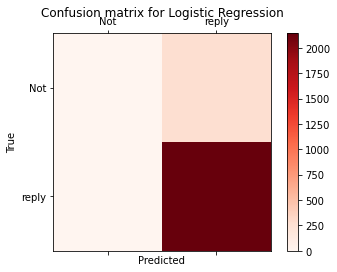

In [226]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(model_test_y, best_LR_model.predict(model_test_x))),
    #("Logistic Regression", confusion_matrix(yc_test,best_LR_model.predict(Xc_test))),
]

draw_confusion_matrices(confusion_matrices)

### ROC & AUC

In [0]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(model_test_x)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(model_test_y, y_pred_lr)

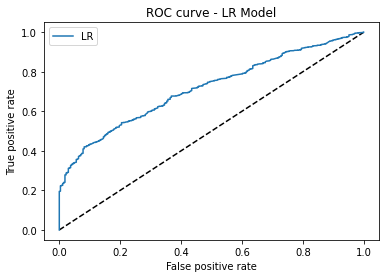

In [228]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [229]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

0.7152249902901848

## Feature selection

In [231]:
# Store the coef for feature selection
res = pd.DataFrame(columns=['Feature', 'Coef'])

for k,v in sorted(zip(map(lambda x: round(x, 4), best_LR_model.fit(model_train_x, model_train_y).coef_[0]), \
                      model_train_x.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    #print (v + ": " + str(k))
    res = res.append({'Feature': v, 'Coef': k}, ignore_index=True)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [232]:
res

,Feature,Coef
0,1-10_interactions,-1.603
1,0_reviews,-0.815
2,11-20_interactions*0-150_char_message,0.803
3,11-20_interactions,0.756
4,1-10_interactions*1-30d_lead_time,-0.713
...,...,...
117,>450_char_message*>90d_lead_time,0.024
118,301-450_char_message*61-90d_lead_time,0.023
119,past_booker*11-20_interactions,-0.021
120,151-300_char_message*1-5d_stay,0.011


In [0]:
from google.colab import files

res.to_csv('mod1_res.csv')
files.download('mod1_res.csv')

In [0]:
#interaction = res[res.Feature.str.contains('interaction', regex=False)]
#res_pos = res[res.Coef >= 0]
#res_pos.style.background_gradient(subset=['Coef'], cmap='BuGn')

# Model for replied inquiries

## Split training and test dataset

In [234]:
replied_inquiries = replied_inquiries.drop(['channel', 'accept_t'], axis = 1)
replied_inquiries = replied_inquiries.dropna() # drop fake replies
replied_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14129 entries, 1 to 26390
Columns: 126 entries, reply_t to >450_char_message*>90d_lead_time
dtypes: float64(1), int64(125)
memory usage: 13.7 MB


In [0]:
# The 15% test data will kept aside, they won't be seen by the models until final test/comparison.
from sklearn.model_selection import train_test_split

model_train, model_test = train_test_split(replied_inquiries, test_size=0.15, random_state = 3)
model_train_x = model_train.drop(['replied', 'accepted', 'booked'], axis = 1)
model_test_x = model_test.drop(['replied', 'accepted', 'booked'], axis = 1)
model_train_y = model_train['accepted']
model_test_y = model_test['accepted']

## Train model and find optimal hypermarameters

In [0]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [238]:
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

# Logistic Regression
classifier_logistic = LogisticRegression()

# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2

# ('l1', 1) ('l1', 5), ('l1', 10) ('l2', 1) ('l2', 5), ('l2', 10)
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(1, 5, 10)
    #'C':np.logspace (2, 5, num=20)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5)
Grid_LR.fit(model_train_x, model_train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITER

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': (1, 5, 10), 'penalty': ('l1', 'l2')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [239]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)


Best score: 0.761
Best parameters set:
	C: 1
	penalty: 'l2'


In [0]:
# best model
best_LR_model = Grid_LR.best_estimator_

## Model evaluation

### Confusion matrix

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Accept']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [242]:
confusion_matrix(model_test_y, best_LR_model.predict(model_test_x))

array([[1252,   97],
       [ 438,  333]])

Logistic Regression
Accuracy is: 0.748
precision is: 0.774
recall is: 0.432


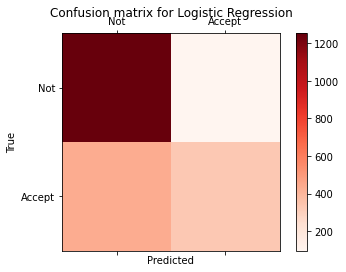

In [243]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(model_test_y, best_LR_model.predict(model_test_x))),
    #("Logistic Regression", confusion_matrix(yc_test,best_LR_model.predict(Xc_test))),
]

draw_confusion_matrices(confusion_matrices)

### ROC & AUC

In [0]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(model_test_x)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(model_test_y, y_pred_lr)

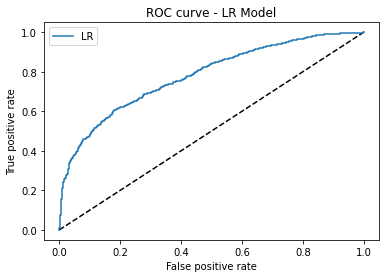

In [245]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [246]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

0.7801340090512356

## Feature selection 

In [249]:
# Store the coef for feature selection
res = pd.DataFrame(columns=['Feature', 'Coef'])

for k,v in sorted(zip(map(lambda x: round(x, 4), best_LR_model.fit(model_train_x, model_train_y).coef_[0]), \
                      model_train_x.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (v + ": " + str(k))
    res = res.append({'Feature': v, 'Coef': k}, ignore_index=True)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


reply_t: -1.1049
1-10_interactions: -1.0785
21-30_interactions*11-15d_stay: 0.9483
>30_interactions*>15d_stay: 0.8806
21-30_interactions*>450_char_message: 0.8627
0_reviews: -0.8603
21-30_interactions: 0.7717
1-10_interactions*>90d_lead_time: -0.7283
21-30_interactions*>15d_stay: -0.5746
contact_me*>90d_lead_time: 0.5299
>30_interactions: 0.5146
past_booker*>30_interactions: 0.509
21-30_reviews: 0.5034
>30_interactions*>450_char_message: -0.5009
>30_reviews: 0.4927
1-10_interactions*1-5d_stay: -0.486
>30_interactions*151-300_char_message: 0.4131
contact_me: 0.4108
21-30_interactions*>90d_lead_time: 0.4104
contact_me*1-30d_lead_time: -0.4094
>30_interactions*11-15d_stay: -0.4076
21-30_interactions*0-150_char_message: -0.4035
1-10_interactions*301-450_char_message: -0.3606
1-10_interactions*151-300_char_message: -0.3539
11-20_interactions*>15d_stay: -0.3537
>30_interactions*301-450_char_message: 0.3519
contact_me*61-90d_lead_time: 0.3509
past_booker*1-10_interactions: -0.3465
>30_interac

In [248]:
res

,Feature,Coef
0,reply_t,-1.105
1,1-10_interactions,-1.079
2,21-30_interactions*11-15d_stay,0.948
3,>30_interactions*>15d_stay,0.881
4,21-30_interactions*>450_char_message,0.863
...,...,...
118,0-150_char_message*1-5d_stay,-0.009
119,21-30_interactions*1-30d_lead_time,0.009
120,>450_char_message,0.007
121,61-90d_lead_time,-0.003


In [0]:
from google.colab import files

res.to_csv('mod2_res.csv')
files.download('mod2_res.csv')

# Model for accepted inquiries (contact me only)

## Split training and test dataset

In [0]:
drop_columns = []

for c in accepted_inquiries.columns:
  if 'contact_me' in c:
    drop_columns.append(c)


In [251]:
accepted_inquiries = accepted_inquiries.drop(drop_columns, axis = 1)
accepted_inquiries = accepted_inquiries.drop(['reply_t', 'channel'], axis = 1)
accepted_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5169 entries, 3 to 26390
Columns: 115 entries, accept_t to >450_char_message*>90d_lead_time
dtypes: float64(1), int64(114)
memory usage: 4.6 MB


In [252]:
accepted_inquiries.head(10)

,accept_t,replied,accepted,booked,1-10_interactions,11-20_interactions,21-30_interactions,>30_interactions,0_reviews,1-10_reviews,11-20_reviews,21-30_reviews,>30_reviews,1-30d_lead_time,31-60d_lead_time,61-90d_lead_time,>90d_lead_time,1-5d_stay,6-10d_stay,11-15d_stay,>15d_stay,0-150_char_message,151-300_char_message,301-450_char_message,>450_char_message,1_guest,2_guests,3-4_guests,5-6_guests,>6_guests,past_booker,1-10_interactions*0-150_char_message,1-10_interactions*151-300_char_message,1-10_interactions*301-450_char_message,1-10_interactions*>450_char_message,11-20_interactions*0-150_char_message,11-20_interactions*151-300_char_message,11-20_interactions*301-450_char_message,11-20_interactions*>450_char_message,21-30_interactions*0-150_char_message,...,>30_interactions*1-5d_stay,>30_interactions*6-10d_stay,>30_interactions*11-15d_stay,>30_interactions*>15d_stay,past_booker*1-10_interactions,past_booker*11-20_interactions,past_booker*21-30_interactions,past_booker*>30_interactions,0-150_char_message*1-5d_stay,0-150_char_message*6-10d_stay,0-150_char_message*11-15d_stay,0-150_char_message*>15d_stay,151-300_char_message*1-5d_stay,151-300_char_message*6-10d_stay,151-300_char_message*11-15d_stay,151-300_char_message*>15d_stay,301-450_char_message*1-5d_stay,301-450_char_message*6-10d_stay,301-450_char_message*11-15d_stay,301-450_char_message*>15d_stay,>450_char_message*1-5d_stay,>450_char_message*6-10d_stay,>450_char_message*11-15d_stay,>450_char_message*>15d_stay,0-150_char_message*1-30d_lead_time,0-150_char_message*31-60d_lead_time,0-150_char_message*61-90d_lead_time,0-150_char_message*>90d_lead_time,151-300_char_message*1-30d_lead_time,151-300_char_message*31-60d_lead_time,151-300_char_message*61-90d_lead_time,151-300_char_message*>90d_lead_time,301-450_char_message*1-30d_lead_time,301-450_char_message*31-60d_lead_time,301-450_char_message*61-90d_lead_time,301-450_char_message*>90d_lead_time,>450_char_message*1-30d_lead_time,>450_char_message*31-60d_lead_time,>450_char_message*61-90d_lead_time,>450_char_message*>90d_lead_time
3,-0.100,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,0.664,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
33,0.196,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45,-0.100,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
50,-0.100,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
58,-0.100,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
62,-0.100,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
63,0.003,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
68,-0.100,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
75,-0.100,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [0]:
# The 15% test data will kept aside, they won't be seen by the models until final test/comparison.
from sklearn.model_selection import train_test_split

model_train, model_test = train_test_split(accepted_inquiries, test_size=0.15, random_state = 3)
model_train_x = model_train.drop(['replied', 'accepted', 'booked'], axis = 1)
model_test_x = model_test.drop(['replied', 'accepted', 'booked'], axis = 1)
model_train_y = model_train['booked']
model_test_y = model_test['booked']

## Train model and find optimal hypermarameters

In [0]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [255]:
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

# Logistic Regression
classifier_logistic = LogisticRegression()

# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2

# ('l1', 1) ('l1', 5), ('l1', 10) ('l2', 1) ('l2', 5), ('l2', 10)
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(1, 5, 10)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5)
Grid_LR.fit(model_train_x, model_train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alterna

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': (1, 5, 10), 'penalty': ('l1', 'l2')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [256]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)


Best score: 0.885
Best parameters set:
	C: 5
	penalty: 'l2'


In [0]:
# best model
best_LR_model = Grid_LR.best_estimator_

## Model evaluation

### Confusion matrix

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Book']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [259]:
confusion_matrix(model_test_y, best_LR_model.predict(model_test_x))

array([[601,  49],
       [ 60,  66]])

Logistic Regression
Accuracy is: 0.860
precision is: 0.574
recall is: 0.524


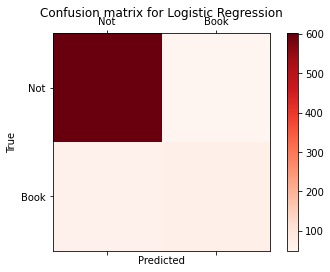

In [260]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(model_test_y, best_LR_model.predict(model_test_x))),
    #("Logistic Regression", confusion_matrix(yc_test,best_LR_model.predict(Xc_test))),
]

draw_confusion_matrices(confusion_matrices)

### ROC & AUC

In [0]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(model_test_x)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(model_test_y, y_pred_lr)

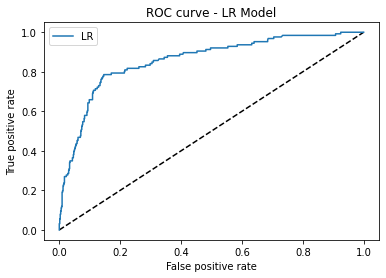

In [262]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [263]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

0.8575152625152626

## Feature selection 

In [264]:
# Store the coef for feature selection
res = pd.DataFrame(columns=['Feature', 'Coef'])

for k,v in sorted(zip(map(lambda x: round(x, 4), best_LR_model.fit(model_train_x, model_train_y).coef_[0]), \
                      model_train_x.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (v + ": " + str(k))
    res = res.append({'Feature': v, 'Coef': k}, ignore_index=True)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


1-10_interactions: -1.8233
>30_interactions*11-15d_stay: 1.2178
>30_interactions: 1.1587
>30_interactions*>90d_lead_time: 0.7535
1-10_interactions*11-15d_stay: -0.7371
>30_interactions*>450_char_message: 0.7042
>30_interactions*151-300_char_message: 0.6729
21-30_interactions: 0.6436
1-10_interactions*>90d_lead_time: -0.618
21-30_interactions*301-450_char_message: 0.5888
1-10_interactions*6-10d_stay: -0.5517
past_booker: 0.5403
>15d_stay: -0.5387
1-10_interactions*301-450_char_message: -0.538
1-10_interactions*61-90d_lead_time: -0.5026
1-10_interactions*151-300_char_message: -0.4812
11-20_interactions*>15d_stay: -0.4756
21-30_interactions*0-150_char_message: 0.468
21-30_interactions*1-30d_lead_time: 0.4604
1-10_interactions*>15d_stay: -0.4481
21-30_interactions*>450_char_message: -0.4274
0-150_char_message*61-90d_lead_time: -0.4223
1-10_interactions*0-150_char_message: -0.4172
301-450_char_message*61-90d_lead_time: 0.4037
1-10_interactions*1-30d_lead_time: -0.4022
0_reviews: -0.4003
11-

In [175]:
res

,Feature,Coef
0,1-10_interactions,-1.658
1,>30_interactions,0.812
2,past_booker,0.652
3,1-10_interactions*6-10d_stay,-0.608
4,1-10_interactions*>90d_lead_time,-0.594
...,...,...
107,21-30_reviews,0.007
108,11-20_interactions*>90d_lead_time,0.006
109,1-10_reviews,-0.006
110,1-30d_lead_time,-0.005


In [0]:
from google.colab import files

res.to_csv('mod3_res.csv')
files.download('mod3_res.csv')